# Neural Networks

In [1]:
import time
import os
import pprint
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import librosa
import librosa.display
import tqdm.notebook as tq
import utils
from tkinter import Tcl # file sorting by name

# Creation of labels

### Dictionary creation for the classes

We want a dictionary indicating a numbeer for each genre:

{0: 'Hip-Hop', 1: 'Pop', 2: 'Folk', 3: 'Rock', 4: 'Experimental', 5: 'International', 6: 'Electronic', 7: 'Instrumental'}

### Creation of the labels vector

In [2]:
def create_single_dataset(folder_path, tracks_dataframe, genre_dictionary):    
    labels = []
   
    _, file_list = get_sorted_file_paths(folder_path)
    
    for i,file in enumerate(file_list):
        #print("considering file:",file, "({}/{})".format(i,len(file_list)))
        track_id_clip_id = file.split('.')[0]
        track_id = track_id_clip_id.split('_')[0]
        #print("track id with clip: {}, track id: {}".format(track_id_clip_id, track_id))
        genre = tracks_dataframe.loc[int(track_id)]
        #print("genre from dataframe: ", genre)
        label = genre_dictionary[genre]
        #print("label from dictionary:",label)
        labels.append(label)
    print("labels length: {}".format(len(labels)))
    return labels
    

#create the train,validation and test vectors using the files in the train/validation/test folders
def create_dataset_splitted(folder_path):
    train_folder = os.path.join(folder_path,'train') # concatenate train folder to path
    validation_folder = os.path.join(folder_path,'validation') # concatenate train folder to path
    test_folder = os.path.join(folder_path,'test') # concatenate train folder to path
    
    print("train_folder:",train_folder)
    print("validation_folder:",validation_folder)
    print("test_folder:",test_folder,"\n")
    
    AUDIO_DIR = os.environ.get('AUDIO_DIR')
    print("audio directory: ",AUDIO_DIR)
    print("Loading tracks.csv...")
    tracks = utils.load('data/fma_metadata/tracks.csv')
    
    #get only the small subset of the dataset
    small = tracks[tracks['set', 'subset'] <= 'small']
    print("small dataset shape:",small.shape)    

    small_training = small.loc[small[('set', 'split')] == 'training']['track']
    small_validation = small.loc[small[('set', 'split')] == 'validation']['track']
    small_test = small.loc[small[('set', 'split')] == 'test']['track']

    print("Track.csv: {} training samples, {} validation samples, {} test samples\n".format(len(small_training), len(small_validation), len(small_test)))

    small_training_top_genres = small_training['genre_top']
    small_validation_top_genres = small_validation['genre_top']
    small_test_top_genres = small_test['genre_top']
    
    #create dictionary of genre classes:
    unique_genres = small_training_top_genres.unique()
    unique_genres = np.array(unique_genres)
    print("there are {} unique genres".format(len(unique_genres)))
    genre_dictionary = {}
    for i,genre in enumerate(unique_genres):
        genre_dictionary[genre] = i
    print("Dictionary of genres created:",genre_dictionary)
    
    
    Y_train = create_single_dataset(train_folder, small_training_top_genres, genre_dictionary)
    Y_validation = create_single_dataset(validation_folder, small_validation_top_genres, genre_dictionary)
    Y_test = create_single_dataset(test_folder, small_test_top_genres, genre_dictionary)
    
    return Y_train, Y_validation, Y_test
 
def get_sorted_file_paths(folder_path):
    file_list = os.listdir(folder_path)
    #sort the dataset files in alphabetical order (important to associate correct labels created using track_id in track.csv)
    file_list = Tcl().call('lsort', '-dict', file_list) # sort file by name: 2_0,2_1, ... 2_9,3_0, ... 400_0,400_1, ...
    file_paths = [os.path.join(folder_path, file_name) for file_name in file_list] #join filename with folder path
    #print("There are {} in the folder: {}".format(len(file_list),file_list))
    return file_paths, file_list
    
    
folder_path="data/fma_small_stft_transposed"
Y_train, Y_validation, Y_test = create_dataset_splitted(folder_path)

train_folder: data/fma_small_stft_transposed/train
validation_folder: data/fma_small_stft_transposed/validation
test_folder: data/fma_small_stft_transposed/test 

audio directory:  ./data/fma_small/
Loading tracks.csv...
small dataset shape: (8000, 52)
Track.csv: 6400 training samples, 800 validation samples, 800 test samples

there are 8 unique genres
Dictionary of genres created: {'Hip-Hop': 0, 'Pop': 1, 'Folk': 2, 'Rock': 3, 'Experimental': 4, 'International': 5, 'Electronic': 6, 'Instrumental': 7}
labels length: 64000
labels length: 8000
labels length: 8000


# Dataset Class

In [3]:
# Define the custom class for accessing our dataset
class MyDataset(Dataset):
    def __init__(self, file_list, labels):
        self.file_list = file_list
        self.labels=labels

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        # returns a training sample and its label
        file_path = self.file_list[idx]
        label = torch.tensor(self.labels[idx])
        stft_vector = torch.tensor(np.load(file_path)) #load from file
        return stft_vector, label

In [4]:
folder_path="data/fma_small_stft_transposed"

train_folder = os.path.join(folder_path,'train') # concatenate train folder to path
validation_folder = os.path.join(folder_path,'validation') # concatenate train folder to path
test_folder = os.path.join(folder_path,'test') # concatenate train folder to path

train_file_paths, _ = get_sorted_file_paths(train_folder)
train_dataset = MyDataset(train_file_paths, Y_train)
print("len of train dataset: ",len(train_dataset))

validation_file_paths, _ = get_sorted_file_paths(validation_folder)
validation_dataset = MyDataset(validation_file_paths, Y_validation)
print("len of validation dataset: ",len(validation_file_paths))

test_file_paths, _ = get_sorted_file_paths(test_folder)
test_dataset = MyDataset(test_file_paths, Y_test)
print("len of test dataset: ",len(test_dataset))

len of train dataset:  64000
len of validation dataset:  8000
len of test dataset:  8000


In [5]:
def check_for_dimension_errors(filepaths):
    error_indexes = []
    progress = 0
    for file in filepaths:
        progress+=1
        print("checked {}/{} files".format(progress,len(filepaths)))
        x = np.load(file)
        if(x.shape != (128,513)):
            error_indexes.append(x)
            print("error")
    print("{} errors found in files: {}".format(len(error_indexes),error_indexes))
    for idx,error in enumerate(error_indexes):
        print("index: {}, shape: {}".format(idx,error.shape))

# Network Architecture Definition (nnet1)

In [6]:
class NNet1(nn.Module):
    def __init__(self):
        super(NNet1, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 128, kernel_size=(4, 513), stride=(1,513))
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 1))
        self.conv2 = nn.Conv2d(128, 128, kernel_size=(4, 1), stride=(1,513))
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 1))
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(4, 1), stride=(1,513))
        self.avgpool = nn.AvgPool2d(kernel_size=(26, 1))
        self.maxpool = nn.MaxPool2d(kernel_size=(26, 1))
        self.flatten = nn.Flatten()
        self.dropout=nn.Dropout(0.2)
        self.dense1 = nn.Linear(512, 300)
        self.dense2 = nn.Linear(300, 150)
        self.dense3 = nn.Linear(150, 8)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x_avg = self.avgpool(x)
        x_max = self.maxpool(x)
        x = torch.cat([x_avg, x_max], dim=1)
        x = self.flatten(x)
        x = self.dense1(x)
        x=self.dropout(x)
        x = self.relu(x)
        x = self.dense2(x)
        x = self.relu(x)
        x = self.dense3(x)
        x = self.softmax(x)
        return x

# Hyperparameters

In [7]:
BATCH_SIZE=32
EPOCHS=10
LEARNING_RATE=0.001

learning_rate_list = [0.01, 0.001, 0.0001]
batch_size_list = [128,256,512]

# Train function

In [8]:
def test(model, validation_dataset, Y_validation):
    #Stop parameters learning
    model.eval()
    
    validation_loader = torch.utils.data.DataLoader(validation_dataset)
    criterion = nn.CrossEntropyLoss()
    correct = 0
    total = 0
    total_loss = 0
    
    with torch.no_grad():
        for inputs, labels in validation_loader:
            
            inputs=inputs.unsqueeze(1)
            #predict label
            outputs = model(inputs)
            #compute loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    

    accuracy = correct / total
    average_loss = total_loss / len(validation_loader)
    model.train()
    return accuracy, average_loss


In [ ]:
def train(model, dataset, batch_size, num_epochs, learning_rate, verbose = False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    val_loss_list=[]
    val_acc_list=[]
    train_loss_list=[]
    train_acc_list=[]
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    if not isinstance(dataset, Dataset):
        raise ValueError("The dataset parameter should be an instance of torch.utils.data.Dataset.")

    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    num_batches = len(data_loader)
    
    
    for epoch in range(num_epochs):
        running_loss = 0.0 
        running_accuracy = 0.0
        #initialize correctly predicted samples
        
        # Initialize the progress bar
        progress_bar = tq.tqdm(total=num_batches, unit="batch")
    
        # Initialize the progress bar description
        progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
        start_time = time.time()
        
        for batch_idx, batch in enumerate(data_loader):
            correct = 0 # reset train accuracy each batch
            
            inputs,labels = batch[0],batch[1]
            inputs = inputs.unsqueeze(1)
            
            # Extract the inputs and targets
            optimizer.zero_grad()
            outputs = model(inputs)
            
            if(verbose == True):
                print("\ninputs shape:",inputs.size(),", content: ",inputs)
                print("\nlabels shape:",labels.size(),", content: ",labels)
                print("\noutputs size:",outputs.size(),"content:",outputs)

            loss = criterion(outputs, labels) #labels need to be a vector of class indexes (0-7) of dim (batch_size)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            #calculate train accuracy
            for index, output in enumerate(outputs):
                max_index = torch.argmax(output).item() #the index with maximum probability
                if(labels[index].item() == max_index):
                    correct += 1
            
                if(verbose==True):
                    print("considering output at index {}:".format(index,output))
                    print("max output index = {}",max_index)
                    if(labels[index].item() == max_index):
                        print("correct! in fact labels[index] = {}, max_index = {}".format(labels[index].item(),max_index))
                    else:
                        print("NOT correct! in fact labels[index] = {}, max_index = {}".format(labels[index].item(),max_index))

            
            accuracy = 100 * correct / batch_size
            running_accuracy += accuracy #epoch running_accuracy
            
            # Update the progress bar description and calculate bps
            #progress_bar.set_postfix({"Loss": running_loss / (batch_idx + 1)})
            average_accuracy = running_accuracy / (batch_idx + 1)
            average_loss = running_loss / (batch_idx + 1)
            progress_bar.set_postfix({"avg_loss": average_loss, "acc": accuracy, "avg_acc": average_accuracy})

            # Update the progress bar
            progress_bar.update(1)
            # Evaluate the model on the validation dataset
        
        #calculate train loss and accuracy
        average_loss = running_loss / len(data_loader)
        average_accuracy = running_accuracy / len(data_loader)
        train_loss_list.append(average_loss)
        train_acc_list.append(average_accuracy)
        
        #calculate validation loss and accuracy
        val_acc, val_loss = test(model, validation_dataset, Y_validation)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
        
        
        print(f"Epoch [{epoch+1}/{num_epochs}],Train Loss: {average_loss:.4f}. Train Accuracy: {average_accuracy} Val Loss: {val_loss} Val Accuracy: {val_acc}")
        progress_bar.close()
    return train_loss_list, train_acc_list, val_loss_list, val_acc_list

In [ ]:
#summary(model, (1, 128, 513))
performance_list = []
model_list = []
directory = 'models/'

for lr in learning_rate_list:   
    for bs in batch_size_list:
        model = NNet1() #reinitialize model
        file_path = directory + 'model' + '_lr_' + str(lr).split('.')[0] + '-' + str(lr).split('.')[1]+ '_bs_' + str(bs)
        print(f"Traing model with batch size={bs}, lr={lr}")
        performance=train(model, train_dataset, batch_size=bs, num_epochs=EPOCHS, learning_rate=lr)
        performance_list.append(performance)
        model_list.append(model)
        print("saving model in", file_path)
        torch.save(model.state_dict(), file_path)
        print(performance_list)

Traing model with batch size=128, lr=0.01


  0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [1/10],Train Loss: 2.1488. Train Accuracy: 12.49375 Val Loss: 2.1490087509155273 Val Accuracy: 0.125


  0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [1/10],Train Loss: 2.1490. Train Accuracy: 12.5 Val Loss: 2.1490087509155273 Val Accuracy: 0.125


  0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [2/10],Train Loss: 2.1490. Train Accuracy: 12.5 Val Loss: 2.1490087509155273 Val Accuracy: 0.125


  0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [3/10],Train Loss: 2.1490. Train Accuracy: 12.5 Val Loss: 2.1490087509155273 Val Accuracy: 0.125


  0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [4/10],Train Loss: 2.1490. Train Accuracy: 12.5 Val Loss: 2.1490087509155273 Val Accuracy: 0.125


  0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [5/10],Train Loss: 2.1490. Train Accuracy: 12.5 Val Loss: 2.1490087509155273 Val Accuracy: 0.125


  0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [6/10],Train Loss: 2.1490. Train Accuracy: 12.5 Val Loss: 2.1490087509155273 Val Accuracy: 0.125


  0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [7/10],Train Loss: 2.1490. Train Accuracy: 12.5 Val Loss: 2.1490087509155273 Val Accuracy: 0.125


  0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [8/10],Train Loss: 2.1490. Train Accuracy: 12.5 Val Loss: 2.1490087509155273 Val Accuracy: 0.125


  0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [9/10],Train Loss: 2.1490. Train Accuracy: 12.5 Val Loss: 2.1490087509155273 Val Accuracy: 0.125


  0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [10/10],Train Loss: 2.1490. Train Accuracy: 12.5 Val Loss: 2.1490087509155273 Val Accuracy: 0.125
saving model in models/model_lr_0-01_bs_128
[[[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125], [2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273]]]
Traing model with batch size=256, lr=0.01


  0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [1/10],Train Loss: 2.1484. Train Accuracy: 12.528125 Val Loss: 2.1490087509155273 Val Accuracy: 0.125


  0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [2/10],Train Loss: 2.1490. Train Accuracy: 12.5 Val Loss: 2.1490087509155273 Val Accuracy: 0.125


  0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [3/10],Train Loss: 2.1490. Train Accuracy: 12.5 Val Loss: 2.1490087509155273 Val Accuracy: 0.125


  0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [4/10],Train Loss: 2.1490. Train Accuracy: 12.5 Val Loss: 2.1490087509155273 Val Accuracy: 0.125


  0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [5/10],Train Loss: 2.1490. Train Accuracy: 12.5 Val Loss: 2.1490087509155273 Val Accuracy: 0.125


  0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [6/10],Train Loss: 2.1490. Train Accuracy: 12.5 Val Loss: 2.1490087509155273 Val Accuracy: 0.125


  0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [7/10],Train Loss: 2.1490. Train Accuracy: 12.5 Val Loss: 2.1490087509155273 Val Accuracy: 0.125


  0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [8/10],Train Loss: 2.1490. Train Accuracy: 12.5 Val Loss: 2.1490087509155273 Val Accuracy: 0.125


  0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [9/10],Train Loss: 2.1490. Train Accuracy: 12.5 Val Loss: 2.1490087509155273 Val Accuracy: 0.125


  0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [10/10],Train Loss: 2.1490. Train Accuracy: 12.5 Val Loss: 2.1490087509155273 Val Accuracy: 0.125
saving model in models/model_lr_0-01_bs_256
[[[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125], [2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273]], [[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125], [2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273]]]
Traing model with batch size=512, lr=0.01


  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [1/10],Train Loss: 2.1485. Train Accuracy: 12.44375 Val Loss: 2.1490087509155273 Val Accuracy: 0.125


  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [2/10],Train Loss: 2.1490. Train Accuracy: 12.5 Val Loss: 2.1490087509155273 Val Accuracy: 0.125


  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [3/10],Train Loss: 2.1490. Train Accuracy: 12.5 Val Loss: 2.1490087509155273 Val Accuracy: 0.125


  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [4/10],Train Loss: 2.1490. Train Accuracy: 12.5 Val Loss: 2.1490087509155273 Val Accuracy: 0.125


  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [5/10],Train Loss: 2.1490. Train Accuracy: 12.5 Val Loss: 2.1490087509155273 Val Accuracy: 0.125


  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [6/10],Train Loss: 2.1490. Train Accuracy: 12.5 Val Loss: 2.1490087509155273 Val Accuracy: 0.125


  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [7/10],Train Loss: 2.1490. Train Accuracy: 12.5 Val Loss: 2.1490087509155273 Val Accuracy: 0.125


  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [8/10],Train Loss: 2.1490. Train Accuracy: 12.5 Val Loss: 2.1490087509155273 Val Accuracy: 0.125


  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [9/10],Train Loss: 2.1490. Train Accuracy: 12.5 Val Loss: 2.1490087509155273 Val Accuracy: 0.125


  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [10/10],Train Loss: 2.1490. Train Accuracy: 12.5 Val Loss: 2.1490087509155273 Val Accuracy: 0.125
saving model in models/model_lr_0-01_bs_512
[[[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125], [2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273]], [[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125], [2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273]], [[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125], [2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273]]]
Traing model with batch

  0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [1/10],Train Loss: 1.9344. Train Accuracy: 32.859375 Val Loss: 1.9122745493501425 Val Accuracy: 0.35275


  0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [2/10],Train Loss: 1.9036. Train Accuracy: 36.2671875 Val Loss: 1.9172266080379485 Val Accuracy: 0.353


  0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [3/10],Train Loss: 1.8897. Train Accuracy: 37.884375 Val Loss: 1.914251158580184 Val Accuracy: 0.35525


  0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [4/10],Train Loss: 1.8700. Train Accuracy: 39.7453125 Val Loss: 1.8817764599770308 Val Accuracy: 0.387375


  0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [5/10],Train Loss: 1.8914. Train Accuracy: 37.86875 Val Loss: 1.9169727702736854 Val Accuracy: 0.354


  0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [6/10],Train Loss: 1.9876. Train Accuracy: 28.528125 Val Loss: 1.996893467321992 Val Accuracy: 0.276875


  0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [7/10],Train Loss: 2.0914. Train Accuracy: 18.2515625 Val Loss: 2.07832046996057 Val Accuracy: 0.195625


  0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [8/10],Train Loss: 2.0782. Train Accuracy: 19.5765625 Val Loss: 2.060501457422972 Val Accuracy: 0.2135


  0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [9/10],Train Loss: 2.1157. Train Accuracy: 15.83125 Val Loss: 2.1483837509155275 Val Accuracy: 0.125625


  0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [10/10],Train Loss: 2.1490. Train Accuracy: 12.5015625 Val Loss: 2.1490087509155273 Val Accuracy: 0.125
saving model in models/model_lr_0-001_bs_128
[[[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125], [2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273]], [[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125], [2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273]], [[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125], [2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273]], [[0.35275, 0.353

  0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [1/10],Train Loss: 1.9106. Train Accuracy: 35.0859375 Val Loss: 1.896410737067461 Val Accuracy: 0.3675


  0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [2/10],Train Loss: 1.8616. Train Accuracy: 40.4421875 Val Loss: 1.8522914710491896 Val Accuracy: 0.412375


  0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [3/10],Train Loss: 1.8395. Train Accuracy: 42.84375 Val Loss: 1.8260197767913342 Val Accuracy: 0.439375


  0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [4/10],Train Loss: 1.8156. Train Accuracy: 45.21875 Val Loss: 1.8525366085767745 Val Accuracy: 0.4135


  0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [5/10],Train Loss: 1.7958. Train Accuracy: 47.28125 Val Loss: 1.8349460310041905 Val Accuracy: 0.433125


  0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [6/10],Train Loss: 1.7959. Train Accuracy: 47.403125 Val Loss: 1.8046241473853588 Val Accuracy: 0.465375


  0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [7/10],Train Loss: 1.7912. Train Accuracy: 47.8765625 Val Loss: 1.8275287748426199 Val Accuracy: 0.440875


  0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [8/10],Train Loss: 1.7880. Train Accuracy: 48.10625 Val Loss: 1.8104271434694528 Val Accuracy: 0.4605


  0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [9/10],Train Loss: 1.7655. Train Accuracy: 50.4625 Val Loss: 1.8292202703207732 Val Accuracy: 0.4445


  0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [10/10],Train Loss: 1.7659. Train Accuracy: 50.4140625 Val Loss: 1.8237933877855539 Val Accuracy: 0.447125
saving model in models/model_lr_0-001_bs_256
[[[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125], [2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273]], [[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125], [2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273]], [[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125], [2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273]], [[0.35275, 0.

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [1/10],Train Loss: 1.9143. Train Accuracy: 34.6125 Val Loss: 1.882827129766345 Val Accuracy: 0.376375


  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [2/10],Train Loss: 1.8583. Train Accuracy: 40.7390625 Val Loss: 1.8444042218923569 Val Accuracy: 0.42575


  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [3/10],Train Loss: 1.8276. Train Accuracy: 43.9921875 Val Loss: 1.8413038718253374 Val Accuracy: 0.428875


  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [4/10],Train Loss: 1.8172. Train Accuracy: 45.0578125 Val Loss: 1.8464463885724545 Val Accuracy: 0.42025


  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [5/10],Train Loss: 1.7989. Train Accuracy: 46.990625 Val Loss: 1.8387476181536913 Val Accuracy: 0.428


  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [6/10],Train Loss: 1.7782. Train Accuracy: 49.08125 Val Loss: 1.8239915691167117 Val Accuracy: 0.4415


  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [7/10],Train Loss: 1.7536. Train Accuracy: 51.5921875 Val Loss: 1.8128462145626545 Val Accuracy: 0.455125


  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [8/10],Train Loss: 1.7462. Train Accuracy: 52.3625 Val Loss: 1.8042407598495482 Val Accuracy: 0.46675


  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [9/10],Train Loss: 1.7367. Train Accuracy: 53.3984375 Val Loss: 1.7893701848238706 Val Accuracy: 0.48225


  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [10/10],Train Loss: 1.7353. Train Accuracy: 53.521875 Val Loss: 1.7999915072023869 Val Accuracy: 0.470375
saving model in models/model_lr_0-001_bs_512
[[[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125], [2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273]], [[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125], [2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273]], [[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125], [2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273]], [[0.35275, 0.3

  0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [1/10],Train Loss: 1.9151. Train Accuracy: 35.1765625 Val Loss: 1.8935416251718997 Val Accuracy: 0.371375


  0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [2/10],Train Loss: 1.8556. Train Accuracy: 41.1390625 Val Loss: 1.8745876116603613 Val Accuracy: 0.384375


  0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [3/10],Train Loss: 1.8275. Train Accuracy: 44.0453125 Val Loss: 1.8485859577804804 Val Accuracy: 0.412625


  0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [4/10],Train Loss: 1.7984. Train Accuracy: 47.203125 Val Loss: 1.849452141225338 Val Accuracy: 0.41175


  0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [5/10],Train Loss: 1.7769. Train Accuracy: 49.3703125 Val Loss: 1.8201128201037646 Val Accuracy: 0.44825


  0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [6/10],Train Loss: 1.7571. Train Accuracy: 51.55 Val Loss: 1.8425580082833768 Val Accuracy: 0.428875


  0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [7/10],Train Loss: 1.7429. Train Accuracy: 52.8484375 Val Loss: 1.808242661178112 Val Accuracy: 0.459625


  0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [8/10],Train Loss: 1.7301. Train Accuracy: 54.2140625 Val Loss: 1.8058343342989682 Val Accuracy: 0.4645


  0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [9/10],Train Loss: 1.7184. Train Accuracy: 55.5015625 Val Loss: 1.806230291634798 Val Accuracy: 0.473625


  0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [10/10],Train Loss: 1.7064. Train Accuracy: 56.6515625 Val Loss: 1.8007425208240748 Val Accuracy: 0.473125
saving model in models/model_lr_0-0001_bs_128
[[[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125], [2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273]], [[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125], [2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273]], [[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125], [2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273, 2.1490087509155273]], [[0.35275, 0

  0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [1/10],Train Loss: 1.9325. Train Accuracy: 32.8109375 Val Loss: 1.8994971818625928 Val Accuracy: 0.35675


  0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [2/10],Train Loss: 1.8675. Train Accuracy: 39.80625 Val Loss: 1.8854113938063384 Val Accuracy: 0.372125


  0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [3/10],Train Loss: 1.8452. Train Accuracy: 42.2765625 Val Loss: 1.8769579823166131 Val Accuracy: 0.385125


  0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [4/10],Train Loss: 1.8229. Train Accuracy: 44.5640625 Val Loss: 1.8551166446208953 Val Accuracy: 0.40975


  0%|          | 0/250 [00:00<?, ?batch/s]

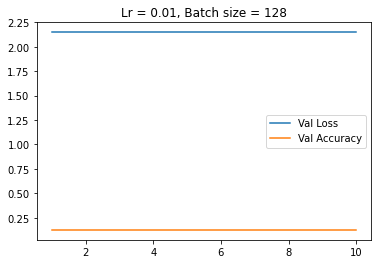

[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]


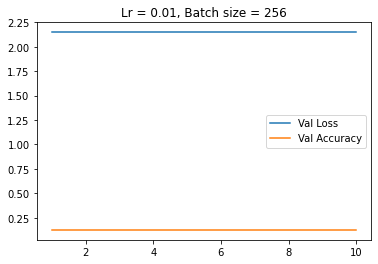

[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]


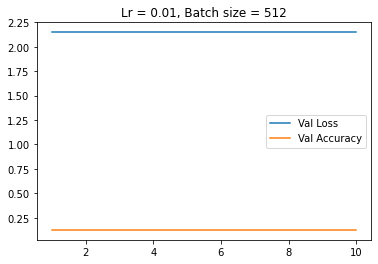

[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]


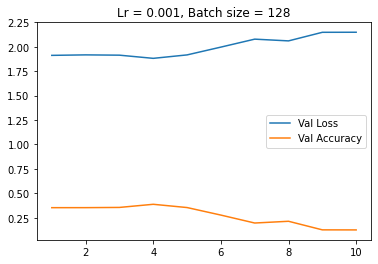

[0.35275, 0.353, 0.35525, 0.387375, 0.354, 0.276875, 0.195625, 0.2135, 0.125625, 0.125]


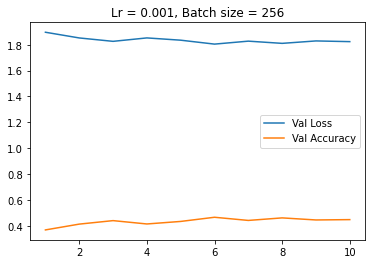

[0.3675, 0.412375, 0.439375, 0.4135, 0.433125, 0.465375, 0.440875, 0.4605, 0.4445, 0.447125]


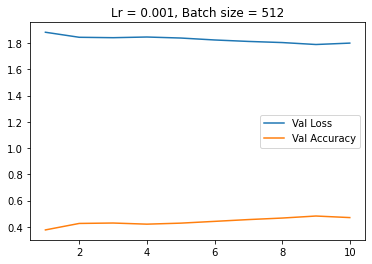

[0.376375, 0.42575, 0.428875, 0.42025, 0.428, 0.4415, 0.455125, 0.46675, 0.48225, 0.470375]


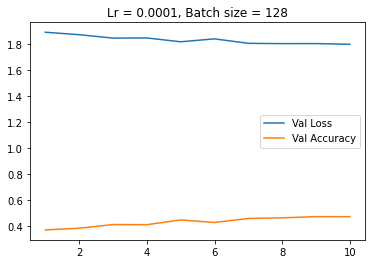

[0.371375, 0.384375, 0.412625, 0.41175, 0.44825, 0.428875, 0.459625, 0.4645, 0.473625, 0.473125]


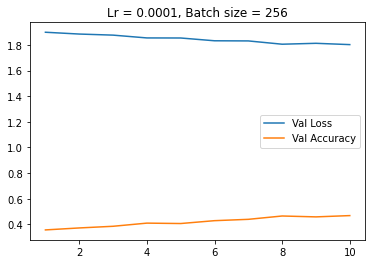

[0.35675, 0.372125, 0.385125, 0.40975, 0.406625, 0.428875, 0.439375, 0.465375, 0.4585, 0.4685]


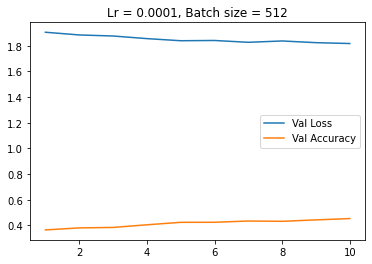

[0.365125, 0.380875, 0.3845, 0.405, 0.42425, 0.424625, 0.434375, 0.432125, 0.44325, 0.4535]


In [40]:
'''
plt.plot(np.arange(1,EPOCHS+1), performance[1][:], label='Loss') 
plt.plot(np.arange(1,EPOCHS+1), performance[0][:], label='Accuracy')
plt.legend()  # Display the legend showing the labels
plt.show()
print(performance[0][:])
'''

parameter_list = []
for lr in learning_rate_list:
    for bs in batch_size_list:
        parameter_list.append([lr,bs])

for performance, parameters in zip(performance_list, parameter_list):
    plt.plot(np.arange(1,EPOCHS+1), performance[1][:], label='Val Loss') 
    plt.plot(np.arange(1,EPOCHS+1), performance[0][:], label='Val Accuracy')
    plt.title(f"Lr = {parameters[0]}, Batch size = {parameters[1]}")
    plt.legend()  # Display the legend showing the labels
    plt.show()
    print(performance[0][:])


# Network Architecture Definition (nnet1 + BN)

In [17]:
class NNet1_BN(nn.Module):
    def __init__(self):
        super(NNet1_BN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 128, kernel_size=(4, 513), stride=(1, 513))
        self.bn1 = nn.BatchNorm2d(128)
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 1))
        self.conv2 = nn.Conv2d(128, 128, kernel_size=(4, 1), stride=(1, 513))
        self.bn2 = nn.BatchNorm2d(128)
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 1))
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(4, 1), stride=(1, 513))
        self.bn3 = nn.BatchNorm2d(256)
        self.avgpool = nn.AvgPool2d(kernel_size=(26, 1))
        self.maxpool = nn.MaxPool2d(kernel_size=(26, 1))
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.2)
        self.dense1 = nn.Linear(512, 300)
        self.bn4 = nn.BatchNorm1d(300)
        self.dense2 = nn.Linear(300, 150)
        self.bn5 = nn.BatchNorm1d(150)
        self.dense3 = nn.Linear(150, 8)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x_avg = self.avgpool(x)
        x_max = self.maxpool(x)
        x = torch.cat([x_avg, x_max], dim=1)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.bn4(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.dense2(x)
        x = self.bn5(x)
        x = self.relu(x)
        x = self.dense3(x)
        x = self.softmax(x)
        return x

In [ ]:
model_NNet1_BN = NNet1_BN()

train_loss_list, train_acc_list, val_loss_list, val_acc_list =train(model_NNet1_BN, train_dataset, batch_size=128, num_epochs=50, learning_rate=0.0001)


  0%|          | 0/500 [00:00<?, ?batch/s]

# Network Architecture Definition (nnet2)

In [10]:
# Define the custom model class
class NNet2(nn.Module):
    def __init__(self):
        super(NNet2, self).__init__()
        self.conv1 = nn.Conv2d(1, 256, kernel_size=(4, 513),padding="same")
        self.conv2 = nn.Conv2d(256, 256, kernel_size=(4, 1),padding="same")
        self.conv3 = nn.Conv2d(256, 256, kernel_size=(4, 1),padding="same")
        self.dense1 = nn.Linear(256*125*1, 300)
        self.dense2 = nn.Linear(300, 150)
        self.dense3 = nn.Linear(150, 8)
        
    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x1 = x  # Save the output of the first convolutional layer for later
        x = nn.ReLU()(self.conv2(x))
        x = nn.ReLU()(self.conv3(x))
        x += x1  # Sum the output of the first convolutional layer with the third convolutional layer
        
        x = torch.cat((nn.AvgPool2d(kernel_size=(125, 1))(x), nn.MaxPool2d(kernel_size=(125, 1))(x)), dim=1)
        x = x.view(x.size(0), -1)
        x = nn.ReLU()(self.dense1(x))
        x = nn.ReLU()(self.dense2(x))
        x = nn.Softmax(dim=1)(self.dense3(x))
        return x

In [11]:
class MusicGenreNet(nn.Module):
    def __init__(self):
        super(MusicGenreNet, self).__init__()
        
        # STFT spectrogram input: (batch_size, 1, 128, 513)
        self.conv1 = nn.Conv2d(1, 256, kernel_size=(4, 513))
        self.conv2 = nn.Conv2d(256, 256, kernel_size=(4, 1))
        self.conv3 = nn.Conv2d(256, 256, kernel_size=(4, 1))
        self.maxpool = nn.MaxPool2d(kernel_size=(125, 1))
        self.avgpool = nn.AvgPool2d(kernel_size=(125, 1))
        self.fc1 = nn.Linear(256, 10)
        self.fc2 = nn.Linear(10, 150)
        self.fc3 = nn.Linear(150, 300)
        self.fc4 = nn.Linear(300, 8)  # 8 classes for genre predictions
        
    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.conv3(x)
        x = torch.relu(x)
        
        # Sum between the first and third conv layers
        x = x[:, :, :, 0] + x[:, :, :, 2]
        x = torch.relu(x)
        
        x = self.maxpool(x)
        x = self.avgpool(x)
        
        # Flatten the tensor for fully connected layers
        x = torch.flatten(x, 1)
        
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        x = torch.relu(x)
        x = self.fc4(x)
        
        return x


In [13]:
# Creating an instance of the network
model = MusicGenreNet()

# Printing the model architecture
print(model)
#summary(model, (1, 128, 513))
train(model, train_dataset, batch_size=32, num_epochs=50, learning_rate=0.001, verbose=True)

MusicGenreNet(
  (conv1): Conv2d(1, 256, kernel_size=(4, 513), stride=(1, 1))
  (conv2): Conv2d(256, 256, kernel_size=(4, 1), stride=(1, 1))
  (conv3): Conv2d(256, 256, kernel_size=(4, 1), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=(125, 1), stride=(125, 1), padding=0, dilation=1, ceil_mode=False)
  (avgpool): AvgPool2d(kernel_size=(125, 1), stride=(125, 1), padding=0)
  (fc1): Linear(in_features=256, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=150, bias=True)
  (fc3): Linear(in_features=150, out_features=300, bias=True)
  (fc4): Linear(in_features=300, out_features=8, bias=True)
)


  0%|          | 0/2000 [00:00<?, ?batch/s]

IndexError: index 2 is out of bounds for dimension 3 with size 1

# Recurrent Neural Network

In [ ]:
class AudioGenreClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(AudioGenreClassifier, self).__init__()
        self.hidden_size = hidden_size
        
        # Time-distributed layer
        self.time_distributed = nn.Linear(input_size, hidden_size)
        
        # Bidirectional LSTM layers
        self.bilstm = nn.LSTM(256, hidden_size, num_layers = num_layers, bidirectional=True)
        
        # Attention mechanism
        self.attention = nn.Linear(hidden_size * 2, 1)
        
        # Pooling layer
        self.pooling = nn.AdaptiveAvgPool1d(1)
        
        # Output layer
        self.fc = nn.Linear(hidden_size * 2, num_classes)
    
    def forward(self, x):
        # Time-distributed layer
        x = self.time_distributed(x)

        # Bidirectional LSTM layers
        output, _ = self.bilstm(x)

        # Attention mechanism
        attention_weights = torch.softmax(self.attention(output), dim=1)
        attended_output = torch.sum(attention_weights * output, dim=1)

        # Pooling layer
        pooled_output = self.pooling(attended_output.permute(0, 1).unsqueeze(2))
        
        # Reshape and pass through the output layer
        pooled_output = pooled_output.squeeze(2)
        output = self.fc(pooled_output)

        return output

In [ ]:
def trainRNN(model, dataset, batch_size, num_epochs, learning_rate):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device: ",device)
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    if not isinstance(dataset, Dataset):
        raise ValueError("The dataset parameter should be an instance of torch.utils.data.Dataset.")

    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    num_batches = len(data_loader)
    
    # Initialize the progress bar
    progress_bar = tq.tqdm(total=num_batches, unit="batch")
    
  
    
    for epoch in range(num_epochs):
        running_loss = 0.0 
        running_accuracy = 0.0
        #initialize correctly predicted samples
        
        # Initialize the progress bar
        progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
        start_time = time.time()
        
        for batch_idx, batch in enumerate(data_loader):
            correct = 0 # reset train accuracy each batch
            
            inputs,labels = batch[0],batch[1]
            #print("inputs shape:",inputs.shape,", content: ",inputs)
            #print("labels shape:",labels.shape,", content: ",labels)
            #inputs = inputs.unsqueeze(1)
            
            # Extract the inputs and targets
            optimizer.zero_grad()
            
            outputs = model(inputs)
            
            #print("\noutputs type:",type(outputs),"content:",outputs)
            #print("\nlabels type:",type(labels),"content:",labels)

            loss = criterion(outputs, labels.float()) #labels need to be a vector of float, not Long
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            #print("outputs shape:",outputs.size(),"content:",outputs)
            #print("labels shape:",labels.size(),"content:",labels)

            #calculate train accuracy
            for idx, predicted_label in enumerate(outputs):
                #print("predicted_label size:",predicted_label.size(),"content:",predicted_label)
                #print("labels[idx] size:",labels[idx].size(),"content:",labels[idx])
                max_idx = torch.argmax(predicted_label).item() #index with max argument in the one hot predicted label vector
                #print("max_idx content:",max_idx)

                if(labels[idx][max_idx].item() == 1):
                    correct += 1
            
            accuracy = 100 * correct / batch_size
            running_accuracy += accuracy #epoch running_accuracy
            #print("Accuracy = {}".format(accuracy))

            
            # Update the progress bar description and calculate bps
            #progress_bar.set_postfix({"Loss": running_loss / (batch_idx + 1)})
            average_accuracy = running_accuracy / (batch_idx + 1)
            progress_bar.set_postfix({"Batch accuracy": accuracy, "Average accuracy": average_accuracy})



            #bps = (batch_idx + 1) / (time.time() - start_time)

            # Update the progress bar
            progress_bar.update(1)
       


        average_loss = running_loss / len(data_loader)
        average_accuracy = running_accuracy / len(data_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}. Accuracy: {average_accuracy}")
        progress_bar.close()

In [ ]:
modelRNN = AudioGenreClassifier(input_size=513, hidden_size=256, num_layers=5, num_classes=8)
trainRNN(modelRNN, train_dataset, batch_size=32, num_epochs=8, learning_rate=0.1)